# Dashpot - Cyber Physical System

## Author: Davide Roznowicz
-----------------------------------------------------------------------------------------


### Introduction to the scope of the project
In the context of Dashpots, we choose a simple **damped pendolum model** to simulate several possible applications in which we control u to adjust the behaviour of the system to our goals. 

One of our main use cases in mind is an **automatic door that, starting from a completely or partially opened position, is pushed violently by a person** or by effect of some air current: **our goal is to "gently" accompany this door** avoiding it from brutally slamming shut.

In the example of the door, it is important that the door movement is damped before it closes with a violent impact. We therefore set the experiments such that the door starts from a certain angle (potentially large) and then it stabilises some degrees before the impact. At that point, when convergence is achieved and angular velocity has decreased by a lot as a consequence, the PID controlled system can just stop and the door will edge towards the closing position because of a mechanism that gets activated and attracts it to close (this is not related to the project).


We are therefore interested in building a system which, generally speaking, satisfies these requirements (more detail in the appropriate Requirement section below):
- **small overshoot**: we do not want the pendolum (or door) to violently touch any surface before the final mechanism is activated
- **settling time** can be longer than usual modelling problems
- **oscillations** should not be too large as this might cause the door internal automatic system to get damaged
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

In [1]:
#----------------------# import standard python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
#----------------------#

#----------------------# import custom python packages
import measures
from Pendolum_Model import Pendolum
import pid_model
#----------------------#

In [2]:
# seed
random.seed(1)
np.random.seed(1)

#----------------------# hyperparameters
frct = 2     # friction
m = 0.01     # mass of the ball
g = 9.8      # gravity
r = 10       # radius of the pendulum

# instance of Pendolum model
model = Pendolum(frct, m, g, r)

## Standard case with no noise | start from 90°

In [3]:
# number of timesteps
num_times = 400

# target angles
angles = [10, 20, 30, 40]

# initial values for theta (in rads) and omega
# starting from 90 degrees and stabilising at target angles
initial_values = [1.5, 0.01]

# noise injected into theta estimates at various timesteps
noise = np.zeros(num_times)




# manual K_p, K_i, K_d optimization:
#
# - the framework was to increase K_p until a reasonable error is achieved.
# - then, K_i was increased a little bit to achieve long term convergence;
#   however, it was not increased much because it would trigger a higher overshoot
# - k_d was then increased

K_i, K_p, K_d = 9, 0.1, -12
PID_model = pid_model.PID(model, K_i, K_p, K_d)

### Simulation with target $\theta_{target} = 10°$

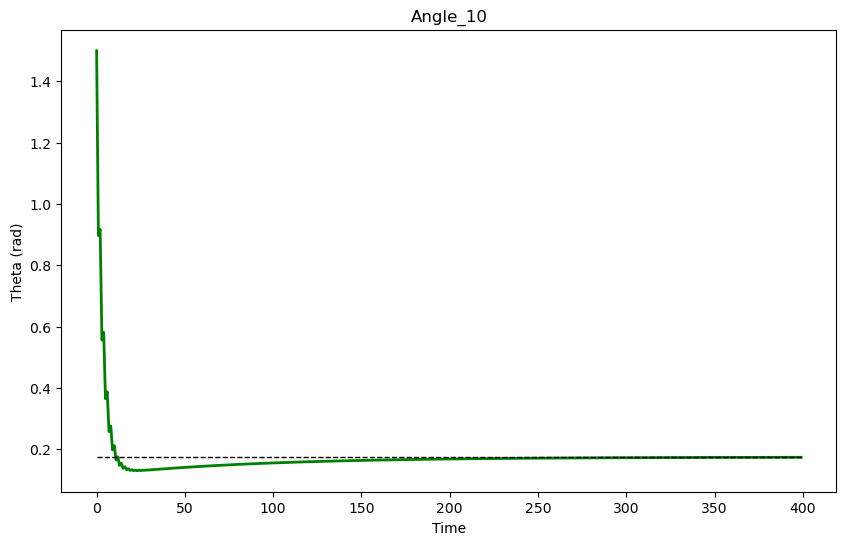

In [4]:
angle = angles[0]


theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [5]:
meas

,Angle_10
overshoot,0.0400
rise time,11.0000
steady state error,0.0006
settling time,348.0000


### Simulation with target $\theta_{target} = 20°$

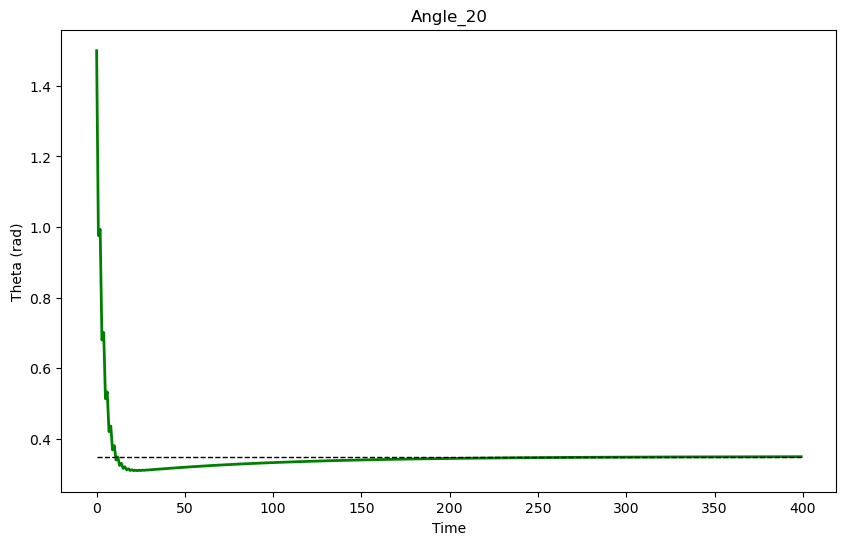

In [5]:
angle = angles[1]


theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [6]:
meas

,Angle_20
overshoot,0.0400
rise time,11.0000
steady state error,0.0006
settling time,344.0000


### Simulation with target $\theta_{target} = 30°$

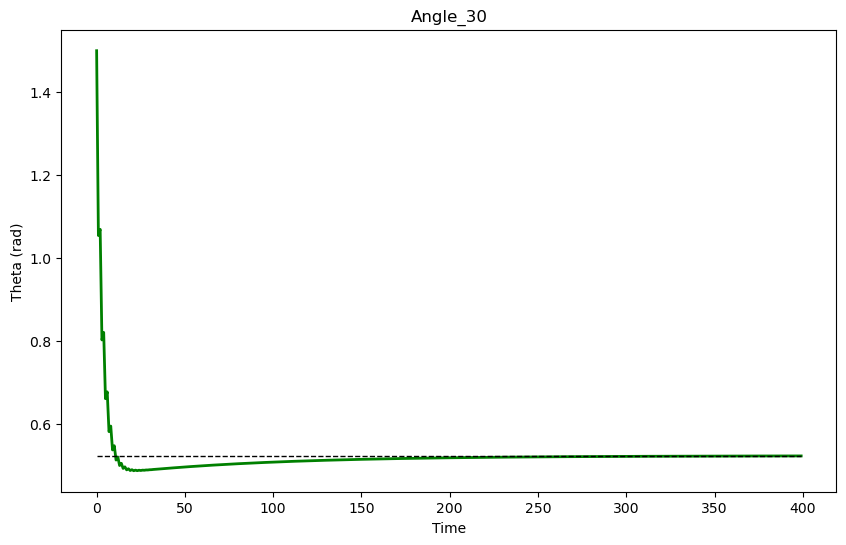

In [7]:
angle = angles[2]

theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [8]:
meas

,Angle_30
overshoot,0.0400
rise time,11.0000
steady state error,0.0005
settling time,340.0000


### Simulation with target $\theta_{target} = 40°$

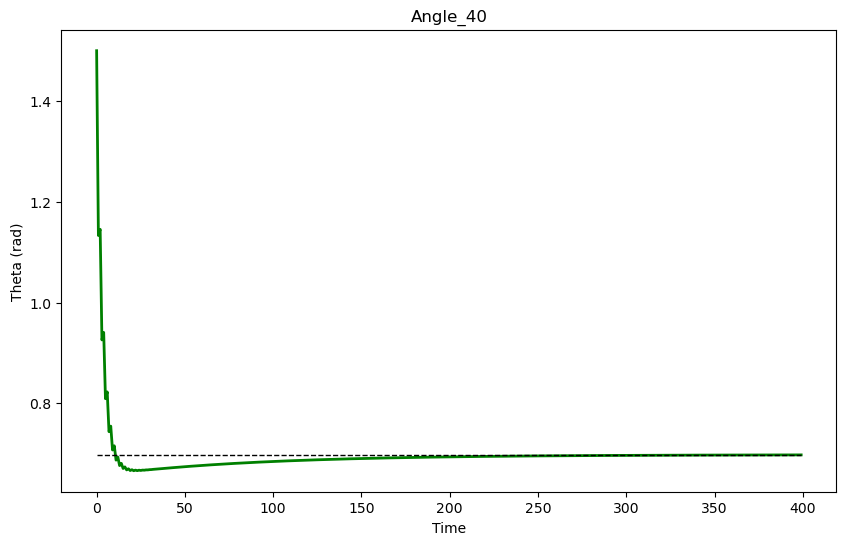

In [9]:
angle = angles[3]


theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [10]:
meas

,Angle_40
overshoot,0.0300
rise time,11.0000
steady state error,0.0004
settling time,334.0000


# Verification of formal Requirements

### Requirements | STL + Moonlight

In [42]:
from moonlight import *

# PHI 1:
# I would like oscillations not to be too strong because it might provoke some
# damages to the dashpot mechanism. Our goal is to preserve its correct movement for the
# long term.
script_short_term_mov = """
signal {real x;}
domain minmax;
formula short_term_mov = globally [10.0, 400.0] (x < 0.1);
"""


# PHI 2:
# we do not want the mechanism
# to have a big overshoot. A small one is ok, but a big one might make the dashpot impact
# brutally with other objects, which is what we want to avoid in the first place.
# In our context, we do not want the angle to exceed 5 degrees, which in rads corresponds
# to 0.08
script_dist = """
signal {real d;}
domain minmax;
formula dist = globally [10.0, 400.0] (d < 0.08);
"""

# PHI 3:
# we always want to the angle to be higher than 5 degrees as we know there is always a
# hard object at 0 degrees
script_max_angle = """
signal {real t; real m; }
domain minmax;
formula max_angle = globally ( t > m );
"""


moonlightScript_oscillation = ScriptLoader.loadFromText(script_short_term_mov)
monitor_1 = moonlightScript_oscillation.getMonitor("short_term_mov")
moonlightScript_distanceref = ScriptLoader.loadFromText(script_dist)
monitor_2 = moonlightScript_distanceref.getMonitor("dist")
moonlightScript_max_angle = ScriptLoader.loadFromText(script_max_angle)
monitor_3 = moonlightScript_max_angle.getMonitor("max_angle")

In [43]:
# model instanciation
model = Pendolum(frct, m, g, r)
PID_model = pid_model.PID(model, K_i, K_p, K_d)

# what to monitor
mons = [monitor_1, monitor_2, monitor_3]

#### Note about Robustness:
The moonlight functions are used to track the signals. The simple idea is that :

- positive values mean that the test has been passed as the signal stays within the boudaries set by the verification requirements
- Negative values mean that the test has failed

The higher the absolute value of the robustness signals, the stronger the signal (both in case of positive or negative outcome).

Last thing to keep into account when reading the tables is that, when min and max are the same, it happens because moonlight returns only one value (i.e. "the most exceeding" value).

### Robustness at varying angles | no noise | start from 90° | initial_omega=0

In [44]:
initial_values = [1.5, 0.00]
noise = np.zeros(num_times)
angles=[10,20,30,40]
max_exceed_angle = 0.08
num_times = 400


df = measures.perform_multiple_robustness(
    PID_model,
    mons,
    initial_values, 
    noise,
    angles=angles, 
    max_exceed_angle=max_exceed_angle, 
    num_times=num_times
)

df

Angle_10                      Angle_20                 \
      Min Robustness Max Robustness Min Robustness Max Robustness   
PHI_1       0.053307       0.053307       0.059404       0.059404   
PHI_2       0.035587       0.035587       0.039664       0.039664   
PHI_3       0.035587       0.079364       0.039664       0.079425   

            Angle_30                      Angle_40                 
      Min Robustness Max Robustness Min Robustness Max Robustness  
PHI_1       0.065502       0.065502       0.071602       0.071602  
PHI_2       0.043832       0.043832       0.048139       0.048139  
PHI_3       0.043832       0.079487       0.048139       0.079551

### Robustness at varying angles | no noise | start from 90° | initial_omega=50

In [45]:
initial_values = [1.5, 50]
noise = np.zeros(num_times)
angles=[10,20,30,40]
max_exceed_angle = 0.08
num_times = 400


df = measures.perform_multiple_robustness(
    PID_model,
    mons,
    initial_values, 
    noise,
    angles=angles, 
    max_exceed_angle=max_exceed_angle, 
    num_times=num_times
)

df

Angle_10                      Angle_20                 \
      Min Robustness Max Robustness Min Robustness Max Robustness   
PHI_1       0.075345       0.075345       0.073527       0.073527   
PHI_2       0.031414       0.031414       0.035450       0.035450   
PHI_3       0.031414       0.079291       0.035450       0.079352   

            Angle_30                      Angle_40                 
      Min Robustness Max Robustness Min Robustness Max Robustness  
PHI_1       0.071711       0.071711       0.069905       0.069905  
PHI_2       0.039405       0.039405       0.043472       0.043472  
PHI_3       0.039405       0.079414       0.043472       0.079479

### Robustness at varying angles | no noise | start from 60° | initial_omega=50

In [46]:
initial_values = [1.0, 50]
noise = np.zeros(num_times)
angles=[10,20,30,40]
max_exceed_angle = 0.08
num_times = 400


df = measures.perform_multiple_robustness(
    PID_model,
    mons,
    initial_values, 
    noise,
    angles=angles, 
    max_exceed_angle=max_exceed_angle, 
    num_times=num_times
)

df

Angle_10                      Angle_20                 \
      Min Robustness Max Robustness Min Robustness Max Robustness   
PHI_1       0.070272       0.070272       0.068466       0.068466   
PHI_2       0.047112       0.047112       0.050967       0.050967   
PHI_3       0.047112       0.079523       0.050967       0.079584   

            Angle_30                      Angle_40                 
      Min Robustness Max Robustness Min Robustness Max Robustness  
PHI_1       0.066666       0.066666       0.064876       0.064876  
PHI_2       0.054914       0.054914       0.058818       0.058818  
PHI_3       0.054914       0.079646       0.058818       0.079709

# Falsification

## Simulation and robustness with noise

1. add perturbations to theta values
2. change initial values and increase angular velocity omega to see how much the PID controller can endure before failing the tests

### 1. Add perturbations to estimates of theta

#### Robustness at varying angles | small noise | start from 90° | initial_omega=0

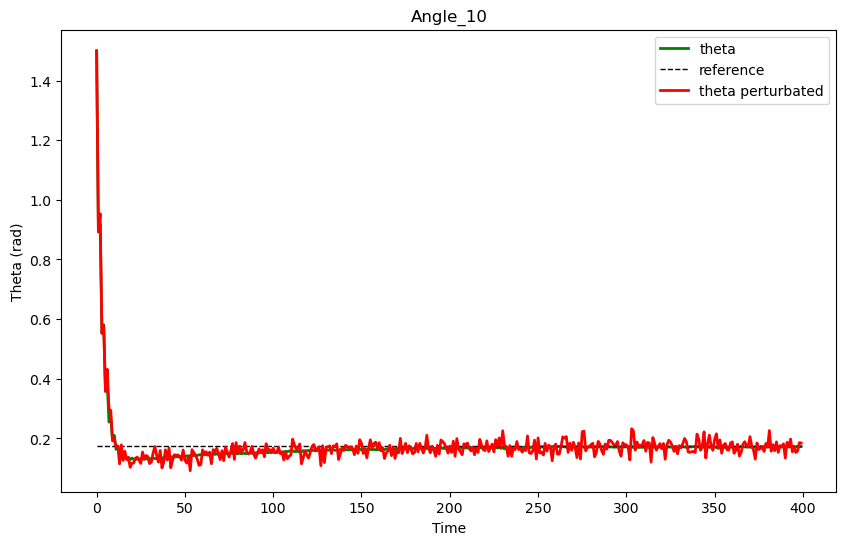

In [47]:
initial_values = [1.5, 0.0]
angle=angles[0]

mean = 0.01
std = 0.2
scaling_factor = 1/10

noise = np.random.normal(mean, std, num_times) * scaling_factor



theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [48]:
angles=[10,20,30,40]
max_exceed_angle = 0.08
num_times = 400


df = measures.perform_multiple_robustness(
    PID_model,
    mons,
    initial_values, 
    noise,
    angles=angles, 
    max_exceed_angle=max_exceed_angle, 
    num_times=num_times
)

df

Angle_10                      Angle_20                 \
      Min Robustness Max Robustness Min Robustness Max Robustness   
PHI_1       0.053303       0.053303       0.059436       0.059436   
PHI_2       0.034466       0.034466       0.038446       0.038446   
PHI_3       0.034466       0.078242       0.038446       0.078301   

            Angle_30                      Angle_40                 
      Min Robustness Max Robustness Min Robustness Max Robustness  
PHI_1       0.065568       0.065568       0.071703       0.071703  
PHI_2       0.042520       0.042520       0.046735       0.046735  
PHI_3       0.042520       0.078362       0.046735       0.078423

#### Robustness at varying angles | bigger noise | start from 90° | initial_omega=0

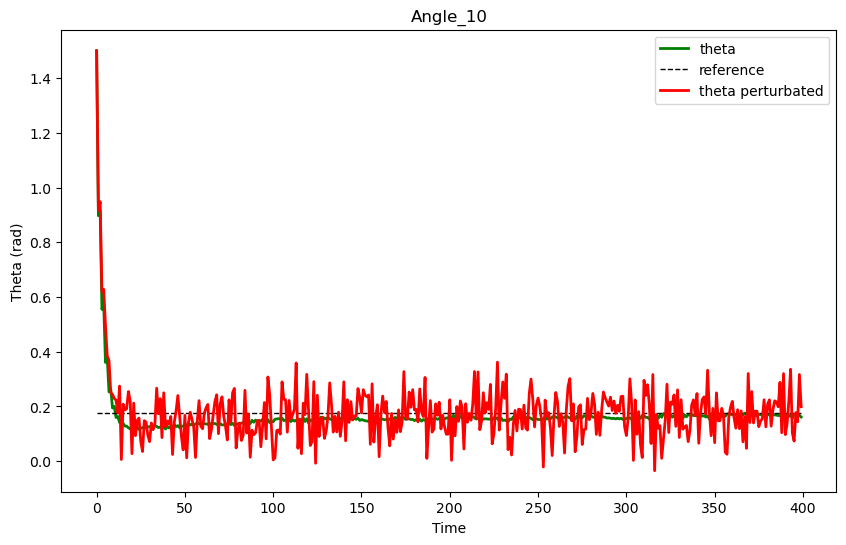

In [49]:
initial_values = [1.5, 0.0]
angle=angles[0]

mean = 0.1
std = 0.7
scaling_factor = 1/10

noise = np.random.normal(mean, std, num_times) * scaling_factor



theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [50]:
angles=[10,20,30,40]
max_exceed_angle = 0.08
num_times = 400


df = measures.perform_multiple_robustness(
    PID_model,
    mons,
    initial_values, 
    noise,
    angles=angles, 
    max_exceed_angle=max_exceed_angle, 
    num_times=num_times
)

df

Angle_10                      Angle_20                 \
      Min Robustness Max Robustness Min Robustness Max Robustness   
PHI_1       0.059496       0.059496       0.065563       0.065563   
PHI_2       0.019461       0.019461       0.023318       0.023318   
PHI_3       0.019461       0.066707       0.023318       0.066782   

            Angle_30                      Angle_40                 
      Min Robustness Max Robustness Min Robustness Max Robustness  
PHI_1       0.071622       0.071622       0.077675       0.077675  
PHI_2       0.027275       0.027275       0.031381       0.031381  
PHI_3       0.027275       0.066866       0.031381       0.066960

### 1. Change initial values - Increase Angular velocity

#### Robustness at varying angles | small noise | start from 90° | initial_omega=50

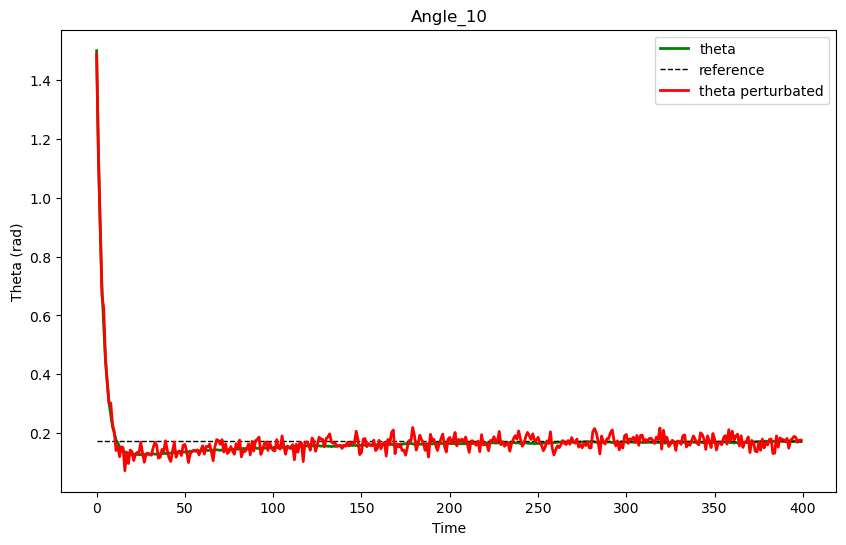

In [51]:
initial_values = [1.5, 50]
angle=angles[0]

mean = 0.01
std = 0.2
scaling_factor = 1/10

noise = np.random.normal(mean, std, num_times) * scaling_factor



theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [52]:
angles=[10,20,30,40]
max_exceed_angle = 0.08
num_times = 400


df = measures.perform_multiple_robustness(
    PID_model,
    mons,
    initial_values, 
    noise,
    angles=angles, 
    max_exceed_angle=max_exceed_angle, 
    num_times=num_times
)

df

Angle_10                      Angle_20                 \
      Min Robustness Max Robustness Min Robustness Max Robustness   
PHI_1       0.076654       0.076654       0.076815       0.076815   
PHI_2       0.030827       0.030827       0.035187       0.035187   
PHI_3       0.030827       0.076679       0.035187       0.076746   

            Angle_30                      Angle_40                 
      Min Robustness Max Robustness Min Robustness Max Robustness  
PHI_1       0.074859       0.074859       0.072909       0.072909  
PHI_2       0.039633       0.039633       0.044216       0.044216  
PHI_3       0.039633       0.076816       0.044216       0.076889

#### Robustness at varying angles | small noise | start from 60° | initial_omega=300

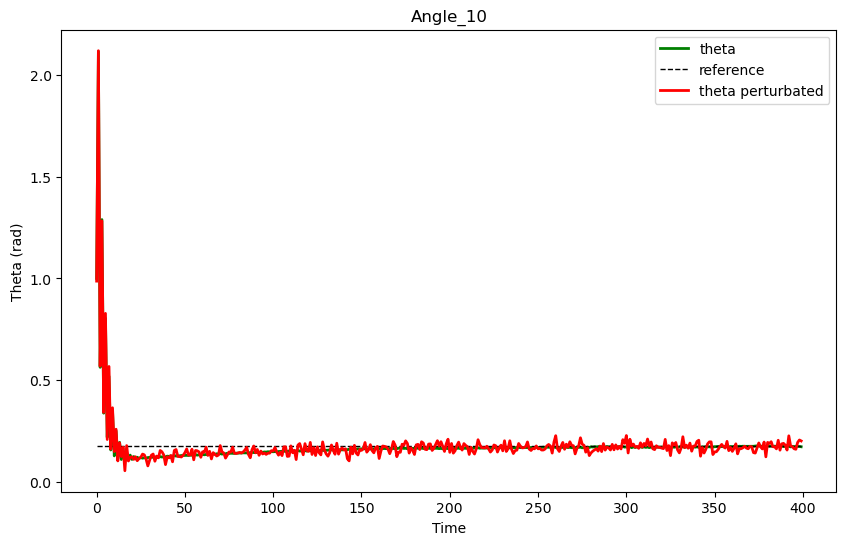

In [53]:
initial_values = [1.0, 300]
angle=angles[0]

mean = 0.01
std = 0.2
scaling_factor = 1/10

noise = np.random.normal(mean, std, num_times) * scaling_factor



theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [54]:
angles=[10,20,30,40]
max_exceed_angle = 0.08
num_times = 400


df = measures.perform_multiple_robustness(
    PID_model,
    mons,
    initial_values, 
    noise,
    angles=angles, 
    max_exceed_angle=max_exceed_angle, 
    num_times=num_times
)

df

Angle_10                      Angle_20                 \
      Min Robustness Max Robustness Min Robustness Max Robustness   
PHI_1      -0.123359      -0.123359      -0.125276      -0.125276   
PHI_2       0.004112       0.004112       0.004632       0.004632   
PHI_3       0.012601       0.077312       0.015703       0.077383   

            Angle_30                      Angle_40                 
      Min Robustness Max Robustness Min Robustness Max Robustness  
PHI_1      -0.127179      -0.127179      -0.129065      -0.129065  
PHI_2       0.005050       0.005050       0.005329       0.005329  
PHI_3       0.015353       0.077459       0.011214       0.077540

Some tests have not passed here. In fact, the system was pushed to the limits on purpose, to have an idea of how it breaks. It is clear from the visualization that high angular velocity (omega) and little delta of the angle (diff between start and target) is causing extremely high short term swings. The second property, regarding the necessity for small overshoot, is still respected.
Further PID parameters optimization might help in designing a better system.

## Let's try to change reference signal

#### Robustness at varying angles | no noise | start from 90° | initial_omega=0

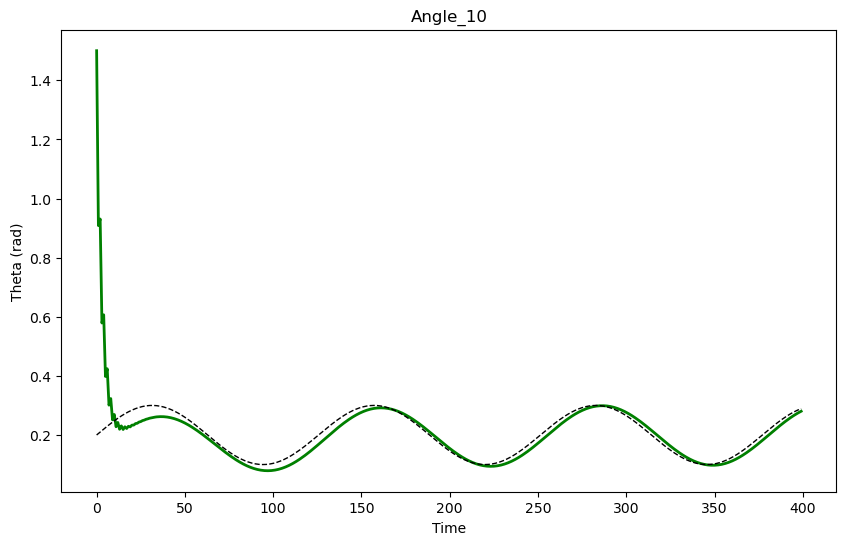

In [55]:
#this is the used signal: [np.sin(i/20)/10 + 0.2 for i in range(num_times)]
sin=True

initial_values = [1.5, 0.01]
noise = np.zeros(num_times)


theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise, sin=sin)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [56]:
angles=[10,20,30,40]
max_exceed_angle = 0.08
num_times = 400


df = measures.perform_multiple_robustness(
    PID_model,
    mons,
    initial_values, 
    noise,
    angles=angles, 
    max_exceed_angle=max_exceed_angle, 
    num_times=num_times
)

df

Angle_10                      Angle_20                 \
      Min Robustness Max Robustness Min Robustness Max Robustness   
PHI_1       0.053313       0.053313       0.059410       0.059410   
PHI_2       0.035586       0.035586       0.039664       0.039664   
PHI_3       0.035586       0.079364       0.039664       0.079425   

            Angle_30                      Angle_40                 
      Min Robustness Max Robustness Min Robustness Max Robustness  
PHI_1       0.065507       0.065507       0.071607       0.071607  
PHI_2       0.043831       0.043831       0.048138       0.048138  
PHI_3       0.043831       0.079487       0.048138       0.079551

### Now Adding noise

#### Robustness at varying angles | bigger noise | start from 90° | initial_omega=0

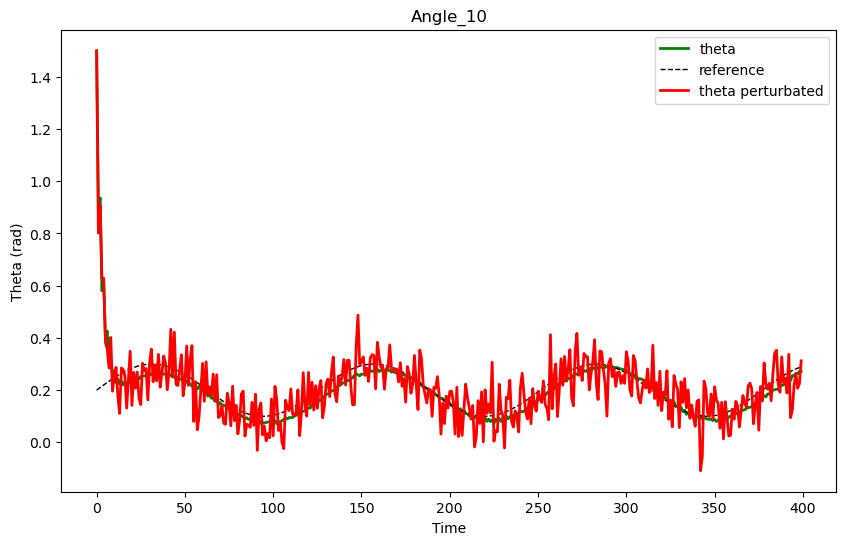

In [57]:
mean = 0.1
std = 0.7
scaling_factor = 1/10

noise = np.random.normal(mean, std, num_times) * scaling_factor

theta_store, theta_store_with_noise, omega_store, ref_store, ts = PID_model.run(angle, num_times-1, num_times, initial_values, noise, sin=sin)
meas = measures.display_performances(angle, theta_store, ref_store, ts)
PID_model.plot(angle, theta_store, theta_store_with_noise, omega_store, ref_store, ts)

In [58]:
angles=[10,20,30,40]
max_exceed_angle = 0.08
num_times = 400


df = measures.perform_multiple_robustness(
    PID_model,
    mons,
    initial_values, 
    noise,
    angles=angles, 
    max_exceed_angle=max_exceed_angle, 
    num_times=num_times
)

df

Angle_10                      Angle_20                 \
      Min Robustness Max Robustness Min Robustness Max Robustness   
PHI_1       0.050079       0.050079       0.056244       0.056244   
PHI_2       0.031617       0.031617       0.035005       0.035005   
PHI_3       0.031617       0.071204       0.035005       0.071257   

            Angle_30                      Angle_40                 
      Min Robustness Max Robustness Min Robustness Max Robustness  
PHI_1       0.062415       0.062415       0.068593       0.068593  
PHI_2       0.038480       0.038480       0.042077       0.042077  
PHI_3       0.038480       0.071306       0.042077       0.071353

The model seems capable of following other target signals as well, which is good. Robustness measurement are within the norm as well.